# DS4440 - Practical Neural Networks
## Understanding Autoencoders

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement
In this notebook, we'll learn about Autoencoders using the Fashion MNIST dataset. Autoencoders are a type of neural network designed to learn efficient representations of data by compressing and reconstructing it.

### We will:
- Build an Autoencoder to compress and reconstruct images from the Fashion MNIST dataset
- Explore how Autoencoders can be used for image denoising and anomaly detection

### What makes Autoencoders special?
- They consist of an encoder that compresses input data and a decoder that reconstructs it
- Autoencoders learn to capture essential features without manual labeling
- They can be used for dimensionality reduction, noise removal, and generative modeling

## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [1]:
! pip install -r requirements.txt

## 1. Data Gathering

### **About the Dataset**

The Fashion MNIST dataset consists of **70,000 labeled grayscale images**, each with a resolution of **28x28 pixels and 10 distinct classes**. This structured dataset allows us to experiment with building and training models, tuning hyperparameters, and evaluating performance.


Each example in the dataset is assigned to one of the following labels:

0 T-shirt/top<br/>
1 Trouser<br/>
2 Pullover<br/>
3 Dress<br/>
4 Coat<br/>
5 Sandal<br/>
6 Shirt<br/>
7 Sneaker<br/>
8 Bag<br/>
9 Ankle boot
<br/>
<br/>

**Dataset Source**
<br/>
The Fashion MNIST Dataset is a very popular dataset, which is already present in the torch library. What we're going to do is that we will fetch this dataset from torch and download it in our current working directory.
<br/><br/>

**What is the below cell doing?**<br/>
The below cell downloads the Fashion MNIST images in the current working directory. Torch offers **60,000** images as training images and **10,000** images as testing images. 



In [2]:
from torchvision import datasets, transforms

# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors (values between 0 and 1)
    # transforms.Normalize((0.5,), (0.5,))  # Center the data around 0 (-1 to 1)
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)


### In this notebook, we will pass the images through the neural network. But, there are a few extra steps that needs to be performed. 

#### Setting up Data Loaders
##### What are dataloaders ? 
Data Loaders help us organize and load our data into our model in small chunks, so the model can learn from the data one batch at a time. 

##### Why do we need them ? 
- **Efficient memory usage**: Load data in small batches instead of all at once.
- **Faster training**: Process data in batches to speed up learning.
- **Shuffling**: Randomize data order to improve model performance.

##### What do they do ? 
- They create several batches of batch_size * (image : label) pairs for the model to learn about patterns in images.

In [3]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Loads the training data in batches of 64 images at a time.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Loads the testing data in batches of 64 images at a time.

#### Visualize an image from a batch

In [4]:
fashion_mnist_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def load_image_from_batch():
    # Get one batch of data from the train_loader
    for images, labels in train_loader:
        # Get the first image from the batch using indexing
        image = images[0]
        label = labels[0]
        break  # Exit the loop after getting the first batch

    # Convert the PIL image to a NumPy array
    image = image[0].numpy()  # Convert the 28x28 image to NumPy array (shape: (28, 28))

    # Display the image using matplotlib
    plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale image
    plt.title("Label: {}".format(fashion_mnist_classes[label.item()]))  # Show the label as the title
    plt.axis('off')  # Hide the axis
    plt.show()

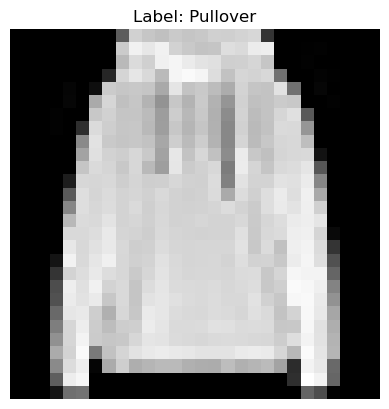

In [6]:
load_image_from_batch()

## 2. Data Wrangling

### Check the size of the training dataset

In [7]:

num_images_train = len(train_dataset)
num_images_test = len(train_dataset)
# Print the number of images in the dataset
print(f"The train dataset has {num_images_train} images")
print(f"The train dataset has {num_images_test} images")


The train dataset has 60000 images
The train dataset has 60000 images


## 3. Model Building

### **AutoEncoders**

### About Autoencoders

Autoencoders are a type of neural network used for unsupervised learning, primarily for tasks like data compression, denoising, and feature learning. The network is trained to map input data to a lower-dimensional representation (encoding) and then reconstruct the original data from this encoding. They are commonly used in dimensionality reduction, anomaly detection, and generative models.

### Key Components:

- **Encoder:**
  The encoder is the first part of the autoencoder network, where the input data is compressed into a lower-dimensional latent space (encoding). This is typically achieved through layers like convolutional layers (in the case of convolutional autoencoders) or fully connected layers.

  For example, in the code:

  ```python
  self.encoder = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.ReLU()
  )
- **Latent Space (Bottleneck)**: The encoding created by the encoder network represents the compressed version of the input. It captures the most important features needed to reconstruct the original data. This part of the network typically has fewer dimensions than the input, forcing the model to learn efficient representations of the data.
- **Decoder**: The decoder takes the lower-dimensional representation (the encoding) and attempts to reconstruct the original input from it. It does the opposite of the encoder by using layers like transposed convolutions (in convolutional autoencoders) or fully connected layers to expand the data back to its original dimensions.
  ```python
  self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
  )
- Activation Functions (ReLU, Sigmoid, etc.): Just like in CNNs, autoencoders use activation functions such as ReLU or Sigmoid after each layer to introduce non-linearity into the network. ReLU is often used in the encoder and decoder layers, while Sigmoid is typically used in the output layer to normalize the values back to a [0, 1] range (for image data).

- **Loss Function (Reconstruction Loss)**: The autoencoder is trained to minimize the reconstruction error between the original input and the reconstructed output. Common loss functions for autoencoders include Mean Squared Error (MSE) for continuous data or Binary Cross-Entropy for binary data.
- **Flattening and Fully Connected Layers (for non-convolutional autoencoders)**: If using a fully connected autoencoder (for non-image data), the encoder typically flattens the input and passes it through several fully connected layers to create the encoding. Similarly, the decoder may use fully connected layers to reconstruct the original data from the encoding.
- **Training the Autoencoder**: The autoencoder is trained using an unsupervised learning approach. The goal is to minimize the reconstruction loss (the difference between the original input and the reconstructed output). During training, the encoder learns to compress the input data efficiently, while the decoder learns to reconstruct the input from this compressed representation.

In [8]:


lr = 0.0001 # learning rate
epochs = 5
batch_size = 64


print('Learning rate:', lr)
print('Batch size:', batch_size)
print('Number of epochs:', epochs)

Learning rate: 0.0001
Batch size: 64
Number of epochs: 5


Note : 
- If the encoder latent space's max valuse is between 0 to 1, then use Sigmoid() at the end of the Decoder <br/>
- If the encoder latent space's max valuse is between -1 to 1, then use Tanh() at the end of the Decoder 


In [9]:
import torch
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [15]:
import torch.nn as nn
class AutoEncoderNN(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
import tqdm
outputs_per_batch = []
def train_model(model, train_loader, criterion, optimizer, epochs=5, device='mps'):
    model.train()  # Set model to training mode
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to device (CPU/GPU)
            images = images.to(device)
            labels = labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            # images = images.view(-1, 28 * 28)
            # Forward pass
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, images)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_loss += loss.item()
        outputs_per_batch.append([epoch, images, outputs])
        # Print progress
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}')

In [13]:
import torch.optim as optim
import torch



device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model = AutoEncoderNN().to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)

train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)


AutoEncoderNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)
encoder.0.weight torch.Size([16, 1, 3, 3])
encoder.0.bias torch.Size([16])
encoder.2.weight torch.Size([32, 16, 3, 3])
encoder.2.bias torch.Size([32])
encoder.4.weight torch.Size([64, 32, 7, 7])
encoder.4.bias torch.Size([64])
decoder.0.weight torch.Size([64, 32, 7, 7])
decoder.0.bias torch.Size([32])
decoder.2.weight torch.Size([32, 16, 3, 3])
decode

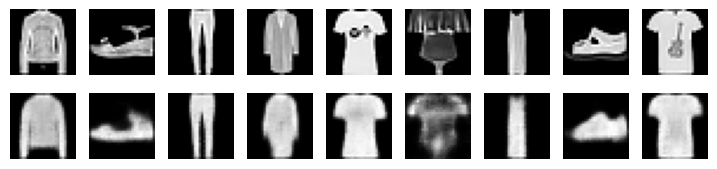

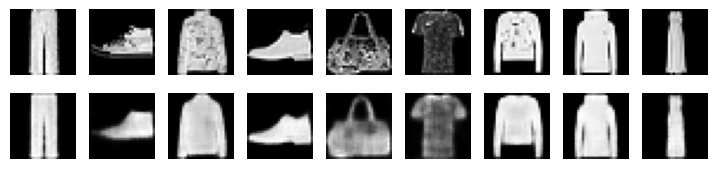

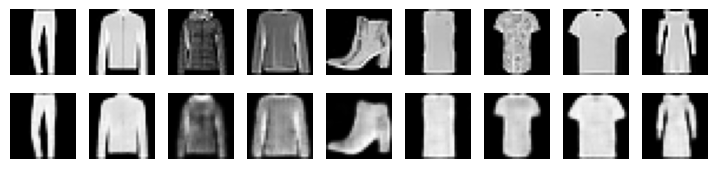

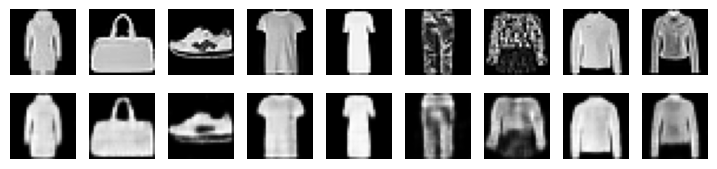

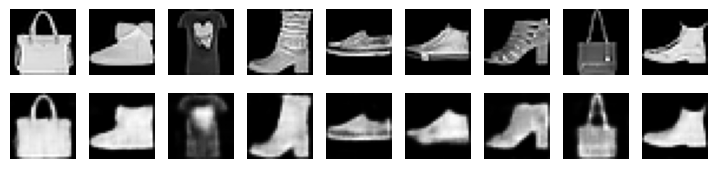

In [14]:
import matplotlib.pyplot as plt
epochs = 10
n = len(outputs_per_batch)
for k in range(0, n, 2):  # Visualize every 2 epochs
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs_per_batch[k][1].detach().cpu().numpy()  # Original images
    recon = outputs_per_batch[k][2].detach().cpu().numpy()  # Reconstructed images
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item.reshape(28, 28))  # Reshape for visualization
        plt.axis('off')  # Hide axis for cleaner visualization

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)  # Row 2 for reconstructed images
        plt.imshow(item.reshape(28, 28))
        plt.axis('off')

    plt.show()  # Display each epoch's results


## 4. Other Visualizations